# Project 6c - Implicit time integration
Recall the matrix form of the equations
$$
\frac{\partial \mathbf{u}}{\partial t} = A \mathbf{u} + \mathbf{b}.
$$
Note that these have been discretized in space, but not in time.  The standard forward Euler method for time integration would read:

$$
\frac{\mathbf{u}_{t+1} - \mathbf{u}_t}{\Delta t} = A \mathbf{u}_{t} + \mathbf{b}.
$$
This works, but requires satisfaction of the CFL condition (a maximum time step).  However, it would also be reasonable to write
$$
\frac{\mathbf{u}_{t+1} - \mathbf{u}_t}{\Delta t} = A \mathbf{u}_{t+1} + \mathbf{b},
$$
in which we solve for the future *in terms of the future*: this is called the Backward Euler method.  This turns out to be a little bit more challenging to solve, but a whole lot more stable.  To see why it's harder to solve, let's rearrange the equation $u_{t+1}$:
$$
\left(\frac{I}\Delta t - A\right)\mathbf{u_{t+1}} = \frac{\mathbf{u}_t}{\Delta t} + \mathbf{b}, 
$$
where I is an appropriately sized identity matrix.  Previously, we were able to compute the new $\mathbf{u}_{t+1}$ directly, but now it's being multiplied by a matrix.  In particular, we could write
$$
L \mathbf{u}_{t+1} = \mathbf{f},
$$
where $L = \left(\frac{I}{\Delta t} - A\right)$ and $\mathbf{f}=\frac{\mathbf{u}_t}{\Delta t} + \mathbf{b}$.  Solving this system of linear equations gives us our update.  

**Develop a new integration method class called BackwardEuler.**  This takes a bit of modification to the problem class as well, because the integrator needs more than just the right hand side of the equations to compute the new value of $\mathbf{u}$.  You can assume that BackwardEuler will have access to two new methods of the problem class called stiffness_matrix (which returns $A$) and load_vector (which returns $\mathbf{b}$), both of which you'll also need to implement (although this is sort of trivial).  

In [1]:
import numpy as np
import ode_methods as om
import matplotlib.pyplot as plt

class Diffusion:
    def __init__(self, nx, dx, k=0.01):
        self.nx = nx
        self.dx = dx
        self.k = k
        self.A = self.create_matrix()
    
    def create_matrix(self):
        A = np.zeros((self.nx, self.nx))
        for i in range(1, self.nx - 1): # Interior points
            # here we use k directly, while in the explicit method we used 1, -2, 1 and then multiplied by k in the right hand side
            A[i, i - 1] = self.k
            A[i, i] = -2 * self.k
            A[i, i + 1] = self.k
        A /= self.dx**2 # Normalizing by dx^2
        return A
    
    def stiffness_matrix(self, dt):
        # Stiffness matrix for Backward Euler
        I = np.identity(self.nx)
        return I / dt - self.A
    
    def load_vector(self, u, dt):
        # Load vector for Backward Euler
        return u / dt

In [2]:
class BackwardEuler:
    def __init__(self):
        pass

    def step(self, ode, t, dt, u_0):
        # Compute the matrix L and vector f for the linear system L*u_{t+1} = f
        L = ode.stiffness_matrix(dt)
        f = ode.load_vector(u_0, dt)
        # Solve the linear system
        return np.linalg.solve(L, f)

In [17]:
def diffuImplicit(_k=0.01, _dt=0.05, _t_span=(0,50)):
    # Setup
    L = 1.0  # Length of the domain
    nx = 100  # Number of grid points
    dx = L / (nx - 1)  # Grid spacing
    x = np.linspace(0, L, nx)  # Position array
    u0 = np.zeros(nx)  # Initial condition array
    u0[0] = 1

    # Parameters
    k = _k  # Diffusion coefficient
    dt = _dt  # Time step
    t_span = _t_span  # Time span

    # Setup model and solver
    ode = Diffusion(nx, dx, k)
    method = BackwardEuler()
    integrator = om.Integrator(ode, method)
    t, u = integrator.integrate(t_span, dt, u0)

    # Visualization
    cmap = plt.cm.viridis
    for tt, uu in zip(t[::10], u[::10]): # Plot every 10th solution
        plt.plot(x, uu, color=cmap(tt/t[-1]))
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Diffusion using Backward Euler")
    plt.show()

**Test your function by comparing it to solutions using forward Euler for similar (stable) time steps.  Does it perform as well?**  

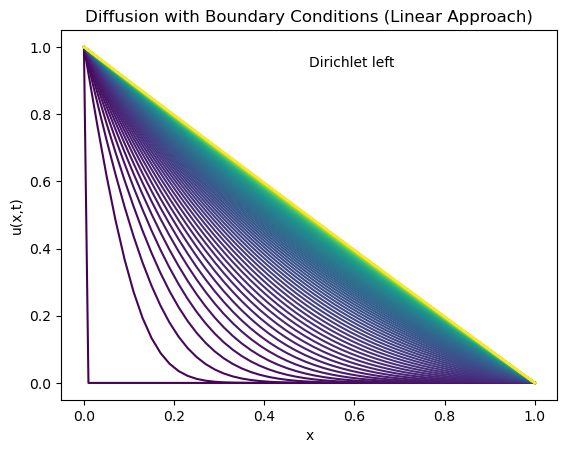

In [6]:
# Forward Euler
from diffusion_models import diffuExplicit

diffuExplicit()

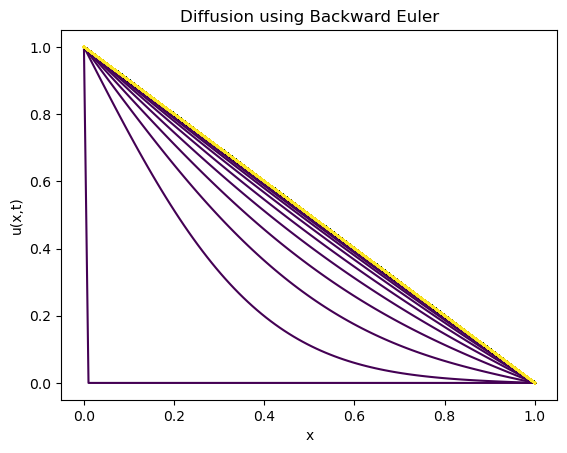

In [18]:
# Backward Euler
diffuImplicit()

**Now try it with increasingly large time steps**.  Does it suffer the same fate as forward Euler?  What is the relative downside to using this method versus forward Euler?  

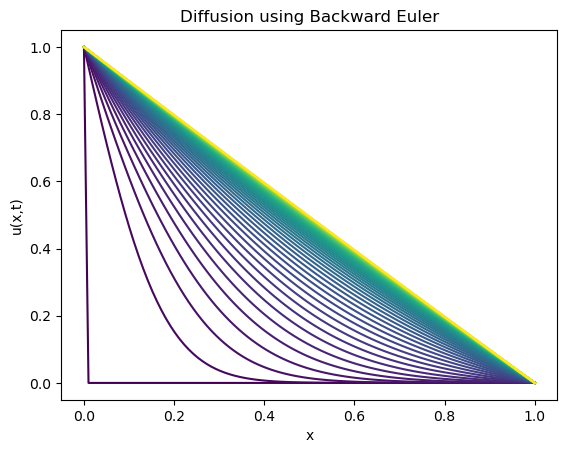

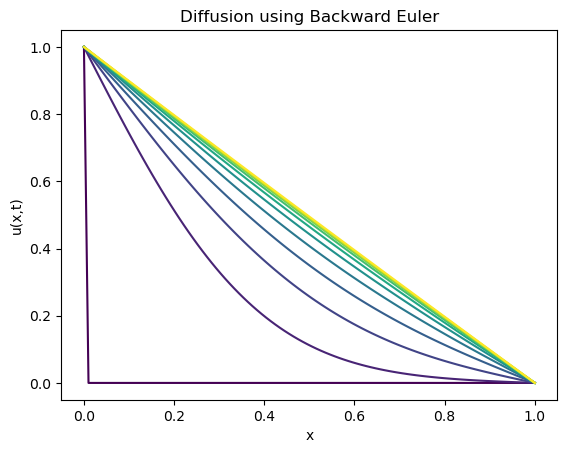

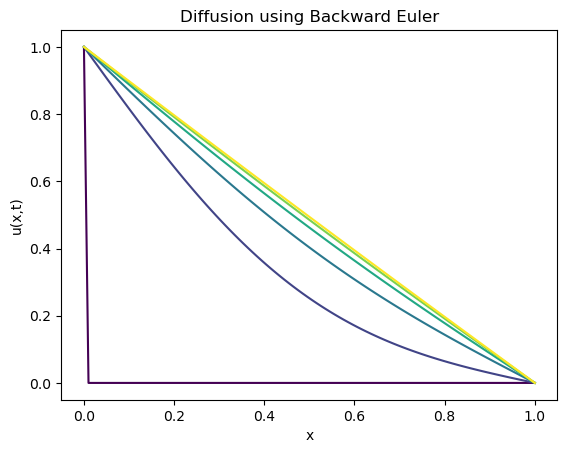

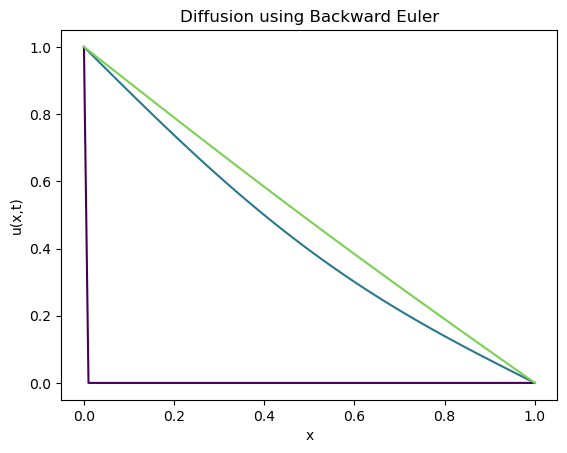

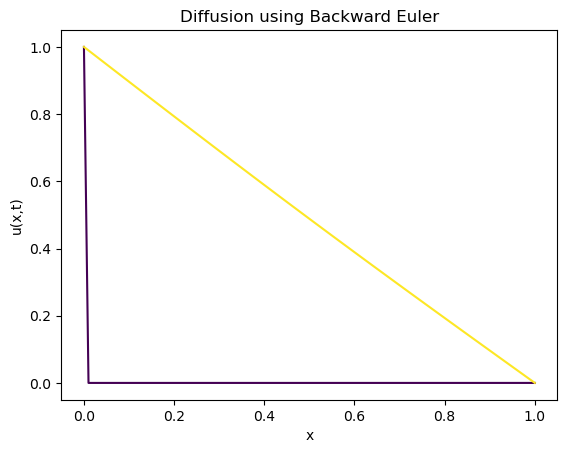

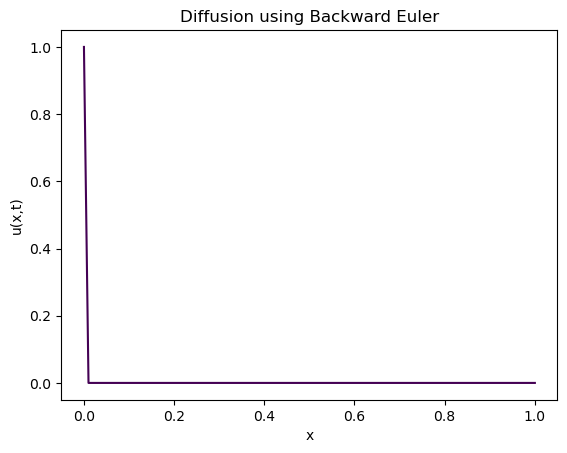

In [12]:
steps = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
for step in steps:
    diffuImplicit(_dt=step)

The relative downside is that the system of equations must be solved at each time step, which is more computationally expensive.  However, the upside is that the time step can be much larger.  This is particularly useful for very large systems of equations, where the cost of solving the system of equations is much less than the cost of computing the right hand side.

**The natural extension of the method described above is to develop a method that computes the steady-state solution, in which the time-derivative is explicitly zero.  Describe and implement a sensible approach.  In particular, consider whether or not the notion of integration through time is even needed anymore.**